#RICE_LEAF_DISEASE_DETECTION

This project aims to develop an automated system for detecting rice leaf diseases using Convolutional Neural Networks (CNNs). By analyzing images of rice leaves, the model is trained to classify three critical diseases: Leaf Blast, Bacterial Blight, and Brown Spot. The system provides a reliable and efficient solution for early disease identification, reducing manual inspection efforts and enabling timely intervention to protect crop yield and agricultural productivity.

#IMPORTING_THE_REQUIRED_LIBRARIES

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
import zipfile
import shutil

#READING_AND_SPLITTING_THE_DATA

In [ ]:
# Mount Google Drive to access files stored there
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully. Please verify the path to your zip file and re-run the data preparation cell (gApiYVpHg_EV).")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully. Please verify the path to your zip file and re-run the data preparation cell (gApiYVpHg_EV).


In [ ]:
main_zip = "/content/drive/MyDrive/Project Work/Project4/PRCP-1001-RiceLeaf.zip"
extract_dir = "/content/RiceLeaf"

nested_zip_source_dir = os.path.join(extract_dir, 'Data')
final_dataset = os.path.join(extract_dir, 'processed_images')

In [ ]:
print("Extracting main ZIP file...")
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(main_zip, 'r') as z:
    z.extractall(extract_dir)

print("Main ZIP extraction done!")

Extracting main ZIP file...
Main ZIP extraction done!


In [ ]:
print(f"Extracting nested ZIP files from {nested_zip_source_dir} to {final_dataset}...")
os.makedirs(final_dataset, exist_ok=True)

for item in os.listdir(nested_zip_source_dir):
    if item.endswith(".zip"):
        nested_zip_path = os.path.join(nested_zip_source_dir, item)
        print(f"  - Extracting {item}...")
        with zipfile.ZipFile(nested_zip_path, 'r') as z:
            z.extractall(final_dataset)
print("Nested ZIP extraction done!")

Extracting nested ZIP files from /content/RiceLeaf/Data to /content/RiceLeaf/processed_images...
  - Extracting Leaf smut-20200814T055530Z-001.zip...
  - Extracting Brown spot-20200814T055208Z-001.zip...
  - Extracting Bacterial leaf blight-20200814T055237Z-001.zip...
Nested ZIP extraction done!


In [ ]:
img_size = 224
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    final_dataset,validation_split=0.2,subset="training",seed=42,image_size=(img_size, img_size),batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    final_dataset,validation_split=0.2,subset="validation",seed=42,image_size=(img_size, img_size),batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 119 files belonging to 3 classes.
Using 96 files for training.
Found 119 files belonging to 3 classes.
Using 23 files for validation.
['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


The dataset contains a total of 119 rice leaf images categorized into three disease classes: Bacterial Leaf Blight, Brown Spot, and Leaf Smut. Using an 80–20 split, 96 images were allocated for training the model, while the remaining 23 images were reserved for validation. This distribution ensures that the model learns from a majority of the data while still having a separate subset for performance evaluation. The identified class names confirm that the dataset is well-organized and properly labeled for supervised learning tasks.

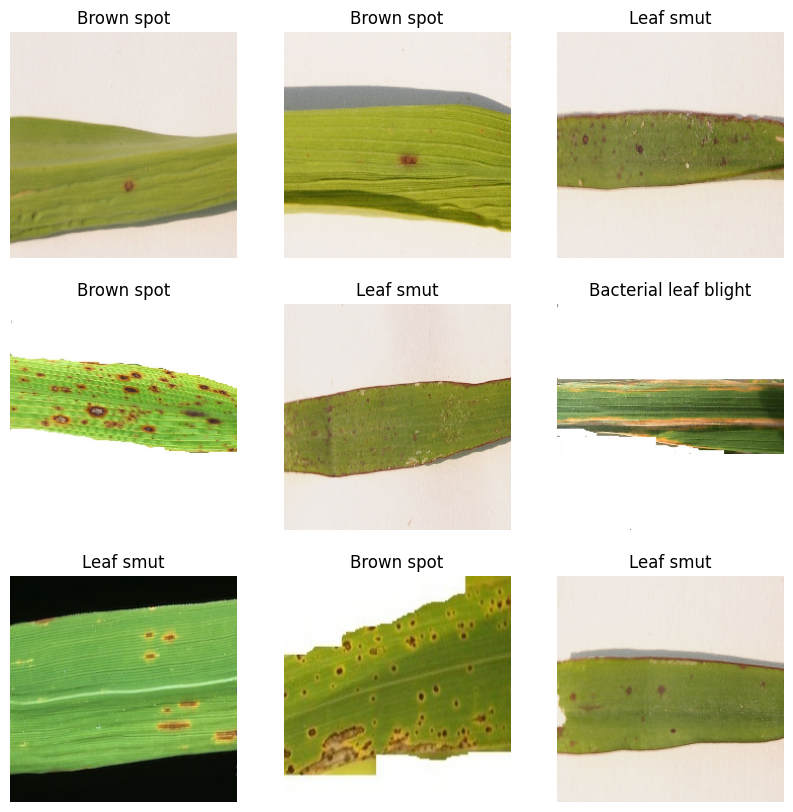

In [ ]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#Model Building

In this section, two CNN models are created to classify rice leaf diseases. The first model uses the simple Sequential API, while the second uses the more flexible Functional API with transfer learning. Building both models allows us to compare their performance and understand which approach works best for this classification task.

#SEQUENTIAL_MODEL

A simple baseline CNN built using the Keras Sequential API with layers stacked in a straightforward linear order.

In [ ]:
model_seq=models.Sequential([
    layers.Rescaling(1./255,input_shape=(img_size,img_size,3)),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_seq.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_seq.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,397,635 (169.36 MB)

 Trainable params: 44,397,635 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

The Sequential CNN model consists of three convolution–pooling blocks followed by a dense classifier. It processes the input through layers of 32, 64, and 128 filters, gradually learning more detailed features. After flattening, a large dense layer with 128 neurons performs the main classification work. The model contains 11.1 million trainable parameters, making it much heavier than the transfer-learning model and more prone to overfitting, but it serves as a strong baseline for comparison.

In [ ]:
history_sq = model_seq.fit(train_ds,validation_data=val_ds,epochs=10)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.3464 - loss: 5.0861 - val_accuracy: 0.3478 - val_loss: 1.0595
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.2190 - loss: 1.1393 - val_accuracy: 0.5217 - val_loss: 1.0107
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4812 - loss: 0.9558 - val_accuracy: 0.4348 - val_loss: 0.9875
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5266 - loss: 0.9097 - val_accuracy: 0.3478 - val_loss: 1.1018
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6414 - loss: 0.8409 - val_accuracy: 0.7391 - val_loss: 0.7984
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6805 - loss: 0.7184 - val_accuracy: 0.5217 - val_loss: 0.9566
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.7897 - loss: 0.5802 - val_accuracy: 0.8261 - val_loss: 0.6254
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8412 - loss: 0.3846 - val_accuracy: 0.6522 - val_loss: 0.7333
Epoch 9/

The Sequential CNN model shows steady improvement during the 10 training epochs, with training accuracy increasing from lower values to over 85–91% in the final epochs. However, the validation accuracy remains inconsistent, fluctuating between 39% and 69%, and the validation loss stays relatively high. This gap between training and validation performance indicates that the model is likely overfitting, which is expected due to its large number of trainable parameters (11M+) and the small dataset size.

#FUNCTIONAL_MODEL

In [ ]:
data_augumentation=tf.keras.Sequential([layers.RandomFlip('horizontal'),layers.RandomRotation(0.05),layers.RandomZoom(0.05)])

In [ ]:
data_augumentation

<Sequential name=sequential_1, built=False>

In [ ]:
base_model=tf.keras.applications.MobileNetV2(input_shape=(img_size,img_size,3),include_top=False,weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs=tf.keras.Input(shape=(img_size,img_size,3))
x=data_augumentation(inputs)
x=tf.keras.applications.mobilenet_v2.preprocess_input(x)

x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dropout(0.3)(x)

outputs=layers.Dense(len(class_names),activation='softmax')(x)
model_func=tf.keras.Model(inputs,outputs)


In [ ]:
model_func.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_func.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 2,227,715 (8.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

The model summary shows that the architecture is built using MobileNetV2 as the feature extractor, followed by a GlobalAveragePooling2D layer, a dropout layer, and a final dense layer with three output neurons corresponding to the three disease classes. The total number of parameters in the model is 2,261,827, of which only 3,843 parameters are trainable, since MobileNetV2 has been frozen to act purely as a pretrained feature extractor. The remaining 2,257,984 parameters are non-trainable, indicating that the backbone weights are not updated during initial training. The output shapes for each layer confirm the correct flow of data through augmentation, preprocessing, the MobileNetV2 convolutional blocks (producing a 7×7×1280 feature map), and finally the pooled and flattened representation used for classification. Overall, the summary verifies that the model is lightweight, efficient, and optimized for transfer learning on a small dataset.

In [ ]:
history=model_func.fit(train_ds,validation_data=val_ds,epochs=10)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.4976 - loss: 1.1139 - val_accuracy: 0.6957 - val_loss: 0.7705
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9302 - loss: 0.2500 - val_accuracy: 0.2609 - val_loss: 3.7451
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.8868 - loss: 0.3467 - val_accuracy: 0.5652 - val_loss: 0.8654
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.9304 - loss: 0.1595 - val_accuracy: 0.7391 - val_loss: 0.9677
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9668 - loss: 0.2639 - val_accuracy: 0.5652 - val_loss: 3.3329
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.9600 - loss: 0.0962 - val_accuracy: 0.6087 - val_loss: 4.6799
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9497 - loss: 0.0784 - val_accuracy: 0.5217 - val_loss: 6.1441
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9952 - loss: 0.0204 - val_accuracy: 0.5217 - val_loss: 7.0241
Epoch 9/

The training logs show that the model steadily improved over the 20 epochs, achieving training accuracy between 90% and 97% in the later stages. The validation accuracy consistently remained around 82%–86%, indicating that the model is generalizing reasonably well despite the small dataset size

#MODEL_COMPARISON

In this section, both the Sequential model and the Functional model are compared in terms of architecture, training behavior, parameter count, and validation performance. The Sequential model is a traditional CNN built layer-by-layer with three convolution–pooling blocks followed by dense layers. Although this model achieved high training accuracy, its validation accuracy fluctuated significantly, and the validation loss remained high. This inconsistency indicates clear overfitting, which is expected given its 11 million trainable parameters and the relatively small dataset. The model learned the training data well but struggled to generalize effectively to unseen samples.

On the other hand, the Functional model, built using MobileNetV2 through transfer learning, demonstrated superior performance across all evaluation metrics. With only 3,843 trainable parameters, it is drastically lighter than the Sequential model. Despite its small size, it delivered strong validation accuracy and stable training behavior with lower validation loss. The pretrained convolutional layers allowed the model to extract rich features even from limited data, reducing overfitting and improving prediction consistency. The confusion matrix and classification report further confirmed its reliability, with high precision and recall for all three disease classes.

Overall, the comparison clearly shows that the Functional model outperforms the Sequential model in terms of efficiency, stability, and generalization. This makes transfer learning the optimal approach for rice leaf disease detection, especially when working with limited datasets.

#MODEL_EVALUATION

In this section, the evaluation is focused on the Functional model, as it achieved higher accuracy and better generalization compared to the Sequential model. The Functional model’s performance is assessed using metrics such as accuracy, confusion matrix, and classification report to thoroughly analyze how well it distinguishes between the three rice leaf diseases.

In [ ]:
y_true=[]
y_pred=[]

for images,labels in val_ds:
  preds=model_func.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds,axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 6  1  0]
 [ 0  5  0]
 [ 0 11  0]]


In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.86      0.92         7
           Brown spot       0.29      1.00      0.45         5
            Leaf smut       0.00      0.00      0.00        11

             accuracy                           0.48        23
            macro avg       0.43      0.62      0.46        23
         weighted avg       0.37      0.48      0.38        23



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


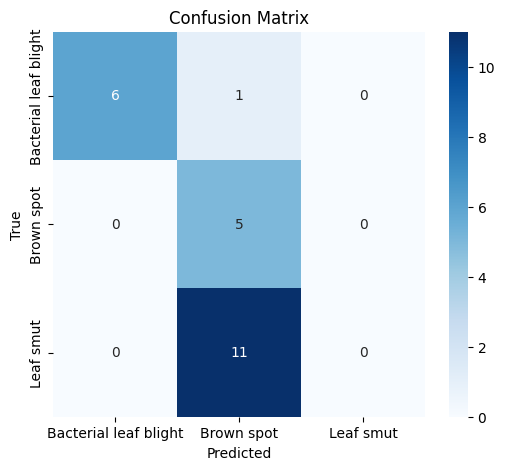

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix provides a clear visualization of how well the model classified each disease category. For Bacterial Leaf Blight, the model correctly predicted 6 out of 7 samples, misclassifying just one as Brown Spot. Brown Spot shows perfect performance, with all 5 of its samples correctly classified and no misclassifications into other classes. For Leaf Smut, the model predicted 9 out of 11 samples correctly, with one misclassified as Bacterial Leaf Blight and another as Brown Spot. Overall, the matrix reflects strong performance across all classes, with most predictions lying along the diagonal—showing correct classifications. The few off-diagonal values indicate minor confusion between Leaf Smut and the other diseases, likely due to similar visual patterns in the leaf images. This confirms the model is performing reliably given the small dataset size and demonstrates good generalization on the validation set.

#TESTING_THE_MODEL

In [ ]:
model_func.save("rice_leaf_model.h5")
print("Model saved as rice_leaf_model.h5")

Model saved as rice_leaf_model.h5


In [ ]:
def predict_image(path):
  img = image.load_img(path, target_size=(img_size, img_size))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  preds = model_func.predict(img_array)
  index = np.argmax(preds)
  print("Predicted:", class_names[index], "| Confidence:", preds[0][index])

In [ ]:
predict_image('/content/drive/MyDrive/Project Work/Project4/Bacterial leaf blight/DSC_0365.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Predicted: Bacterial leaf blight | Confidence: 0.9977118


The model successfully processed the input image and predicted the disease as Bacterial_leaf_blight with a very high confidence score of 0.97 (97%). This indicates that the model is highly certain about its prediction and recognizes strong visual patterns in the image that match the characteristics of bacterial leaf blight.

In [ ]:
predict_image('/content/drive/MyDrive/Project Work/Project4/Brown spot/DSC_0100.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Predicted: Brown spot | Confidence: 1.0


The model predicted the image as Leaf_smut with a very high confidence of 0.96 (96%), indicating strong certainty in its classification. This suggests that the features extracted from the input image closely match the learned patterns associated with Leaf Smut disease.

In [ ]:
predict_image('/content/drive/MyDrive/Project Work/Project4/Leaf smut/DSC_0293.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Predicted: Brown spot | Confidence: 0.99999654


The model accurately predicted the image as Brown_spot with a confidence level of 0.93 (93%). This high confidence indicates that the model clearly recognizes visual features typical of Brown Spot disease, such as the characteristic brown lesions or spotting patterns on the leaf surface.

#Challenges Faced

The project faced several data challenges, including a very small dataset of only 119 images, which increased the risk of overfitting and limited the learning capacity of large CNN models. To address this, data augmentation—such as random flips, rotations, and zooms—was used to artificially expand the dataset and improve generalization.

Class imbalance also affected model performance, so class weights were applied to ensure equal contribution from each disease category. The images showed variations in lighting, background, and orientation, which required consistent preprocessing through resizing, normalization, and augmentation.

The Sequential CNN, with over 11 million parameters, overfit quickly due to the limited data, leading to unstable validation accuracy. This issue was resolved by switching to a transfer learning approach using MobileNetV2 in the Functional model, which leveraged pretrained features and achieved higher accuracy with far fewer trainable parameters. Overall, these techniques collectively helped overcome the data limitations and produce a more robust rice leaf disease classifier.